Epoch 1/100
140/140 [==============================] - 1s 2ms/step - loss: 3.9883 - mae: 1.6321 - val_loss: 2.8910 - val_mae: 1.4245
Epoch 2/100
140/140 [==============================] - 0s 1ms/step - loss: 3.3129 - mae: 1.5033 - val_loss: 2.8229 - val_mae: 1.4101
Epoch 3/100
140/140 [==============================] - 0s 1ms/step - loss: 3.1174 - mae: 1.4695 - val_loss: 2.8376 - val_mae: 1.4153
Epoch 4/100
140/140 [==============================] - 0s 1ms/step - loss: 2.9794 - mae: 1.4300 - val_loss: 2.7006 - val_mae: 1.3856
Epoch 5/100
140/140 [==============================] - 0s 1ms/step - loss: 2.9324 - mae: 1.4299 - val_loss: 2.6170 - val_mae: 1.3655
Epoch 6/100
140/140 [==============================] - 0s 1ms/step - loss: 2.8852 - mae: 1.4146 - val_loss: 2.5913 - val_mae: 1.3569
Epoch 7/100
140/140 [==============================] - 0s 1ms/step - loss: 2.8564 - mae: 1.4079 - val_loss: 2.5548 - val_mae: 1.3488
Epoch 8/100
140/140 [==============================] - 0s 1ms/step - 

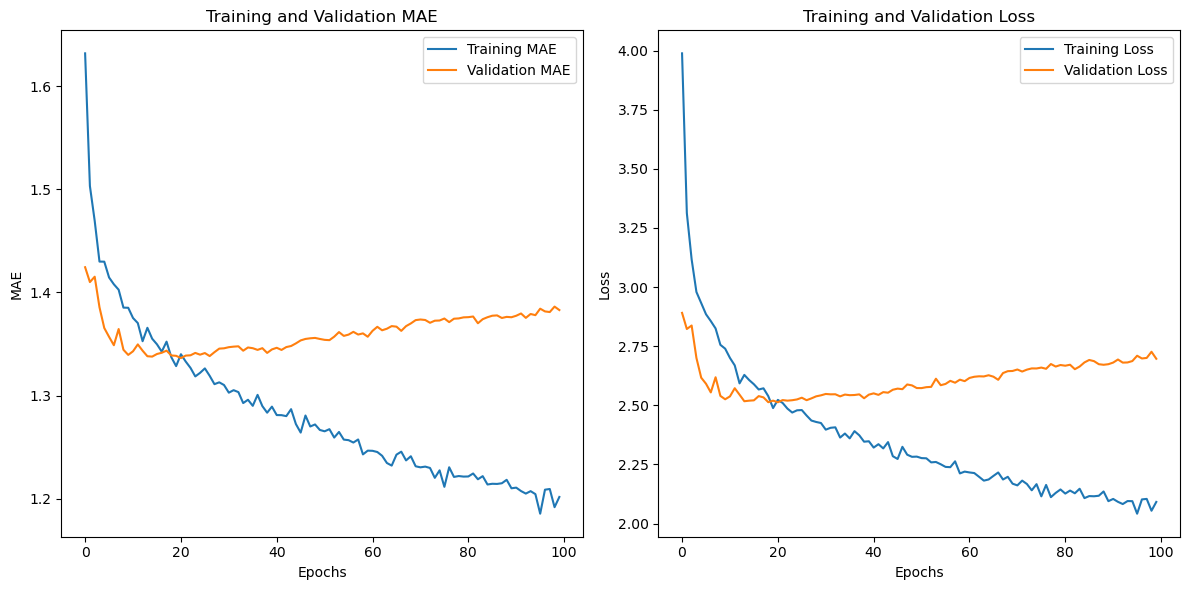

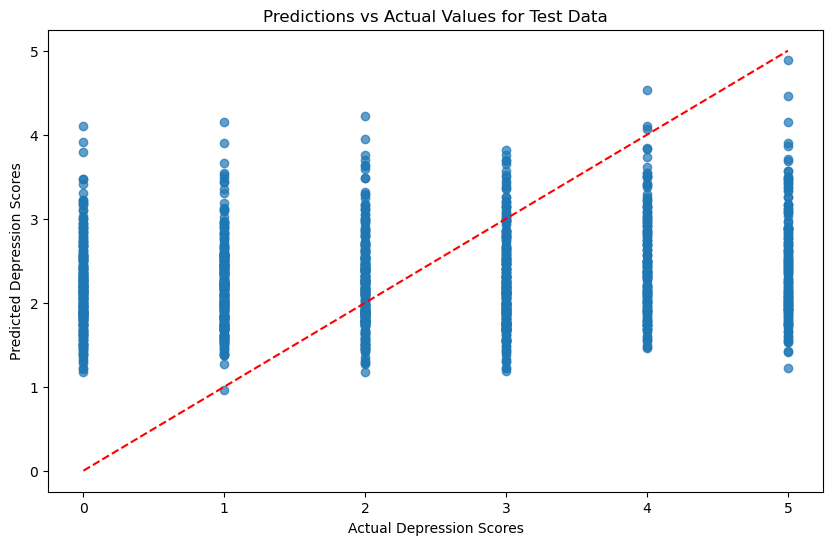

INFO:tensorflow:Assets written to: C:\HealthHack\saved_model\assets


'C:\\HealthHack\\frozen_model\\frozen_graph.pb'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Load data
csv_file_path = 'C:\HealthHack\students_mental_health_survey.csv'
data = pd.read_csv(csv_file_path)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Preprocess data
target_column = 'Depression_Score'
categorical_columns = ['Course', 'Gender', 'Social_Support', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Relationship_Status', 'Substance_Use', 'Counseling_Service_Use', 'Family_History', 'Chronic_Illness', 'Extracurricular_Involvement', 'Residence_Type']
numeric_columns = ['Age', 'CGPA', 'Stress_Level', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load']

target = data[target_column]
features = data.drop(columns=[target_column])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Create model
input_shape = X_train_preprocessed.shape[1]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train model
history = model.fit(X_train_preprocessed, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate model
y_pred = model.predict(X_test_preprocessed)
mae = mean_absolute_error(y_test, y_pred)

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Depression Scores')
plt.ylabel('Predicted Depression Scores')
plt.title('Predictions vs Actual Values for Test Data')
plt.show()

# Save the model
model_save_path = 'C:\\HealthHack\\saved_model'
tf.saved_model.save(model, model_save_path)

# Convert the saved model to a frozen graph

loaded = tf.saved_model.load(model_save_path)
infer = loaded.signatures['serving_default']

frozen_func = convert_variables_to_constants_v2(infer)
frozen_func.graph.as_graph_def()

# Save the frozen graph to a .pb file
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="C:\\HealthHack\\frozen_model",
                  name="frozen_graph.pb",
                  as_text=False)